- **Project Title:** People Counting and Emotion Recognition from Images
- **Team Number:** Group 12
- **Team Members:**
	-	 Manoj Nair
	-	 Tamayi Mlanda

The project is divided into two technical pipelines:

1.  **Object Detection:** Training YOLOv8 to detect and count people.
2.  **Image Classification:** Training a ResNet model (Transfer Learning) to recognize emotions on faces.
3.  **Integration:** A final inference script that combines both.

-----

# Phase 1: Project Selection & Setup

### 1.1 Problem Definition

  * **What is the problem you are going to solve?**
    We are addressing the need for automated situational awareness. The problem involves two distinct tasks: quantification (how many people are in a space) and qualitative analysis (what is the emotional state of these individuals). We aim to build a system that takes a raw image and outputs a count of individuals while simultaneously assessing the "mood" of the scene by analyzing facial expressions.
  * **Why does the problem need to be solved?**
    Manual monitoring of crowds or customer interactions is labor-intensive and not scalable. Automating this solves issues in various domains:
      * **Retail:** Understanding store occupancy vs. customer satisfaction.
      * **Safety:** Crowd counting for occupancy limits.
      * **Security:** Detecting distress (fear/anger) in surveillance feeds.
  * **What aspect of the problem will a computer vision algorithm solve?**
    Computer Vision (CV) serves as the core sensor. We utilize **Object Detection (YOLO)** to localize and count human instances (spatial reasoning) and **Convolutional Neural Networks (CNNs)** to extract facial features and classify them into emotional categories (pattern recognition).

-----

# Phase 2: Environment & Data Setup

**Prerequisite:** You need a Kaggle account and an API token (`kaggle.json`).

### Step 2.1: Library Installation

Run this block to install the necessary state-of-the-art libraries.

In [20]:
# 1. Install Dependencies
!pip install ultralytics kaggle opencv-python-headless matplotlib seaborn torch torchvision --quiet

import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image
from ultralytics import YOLO
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Environment Ready. Using Device: {device}")

✅ Environment Ready. Using Device: cuda


-----

## Step 2.2\. Data Acquisition (Downloading Datasets)

**Action:** Upload your `kaggle.json` file to the Colab files section before running download dataset or generate the kaggle.json using below code.

In [3]:
import json

# 1. PASTE your credentials here (keep the quotes!)
token = {"username": "mannair", "key": "KGAT_6f0092d4ff152cd8463031a8cdb4b646"}

# 2. This code creates the file for you
with open('kaggle.json', 'w') as file:
    json.dump(token, file)

# 3. Move it to the correct folder (standard setup)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API Key created manually!")

Kaggle API Key created manually!


In [4]:
# Setup Kaggle & Download Data
# Ensure kaggle.json is present
if not os.path.exists('kaggle.json'):
    print("⚠️ Please upload kaggle.json to the file system!")
else:
    # Setup API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # A. Download People Detection Dataset
    print("⬇️ Downloading People Detection Dataset...")
    !kaggle datasets download -d adilshamim8/people-detection
    !unzip -q people-detection.zip -d /content/people_dataset

    # B. Download FER2013 (Emotion) Dataset
    print("⬇️ Downloading FER2013 Dataset...")
    !kaggle datasets download -d msambare/fer2013
    !unzip -q fer2013.zip -d /content/fer2013_dataset

    print("✅ All Datasets Downloaded & Extracted.")

⬇️ Downloading People Detection Dataset...
Dataset URL: https://www.kaggle.com/datasets/adilshamim8/people-detection
License(s): Attribution-NoDerivatives 4.0 International (CC BY-ND 4.0)
 97% 1.88G/1.94G [00:12<00:01, 40.7MB/s]
100% 1.94G/1.94G [00:12<00:00, 166MB/s] 
⬇️ Downloading FER2013 Dataset...
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.01GB/s]
✅ All Datasets Downloaded & Extracted.


# Phase 3: EDA and Pre-Processing

## 3.1 Prepare YOLO Labels

To prepare the YOLO labels, we need to parse the _annotations.csv files, convert bounding box coordinates to YOLO format, and save them in the respective labels directories, as specified in the subtask instructions.

In [5]:
import pandas as pd
import os
import cv2 # To get image dimensions easily

# 1. Define a list of dataset splits
splits = ['train', 'valid', 'test']
base_dataset_path = '/content/people_dataset'

# Class ID for 'person' (YOLO typically uses 0 for the first class)
CLASS_ID = 0

def convert_to_yolo_format(bbox, img_width, img_height):
    """Converts [xmin, ymin, xmax, ymax] to YOLO format [x_center, y_center, width, height] (normalized)."""
    xmin, ymin, xmax, ymax = bbox

    # Calculate center, width, height
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2
    width = xmax - xmin
    height = ymax - ymin

    # Normalize by image dimensions
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height

    return f"{CLASS_ID} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}"

for split in splits:
    split_data_path = os.path.join(base_dataset_path, split, split)
    annotations_csv_path = os.path.join(split_data_path, '_annotations.csv')

    # Create labels directory
    labels_dir = os.path.join(base_dataset_path, split, 'labels')
    os.makedirs(labels_dir, exist_ok=True)
    print(f"Processing split: {split}. Labels will be saved to {labels_dir}")

    if not os.path.exists(annotations_csv_path):
        print(f"Warning: _annotations.csv not found for {split} at {annotations_csv_path}. Skipping.")
        continue

    # 4. Read the _annotations.csv file
    df_annotations = pd.read_csv(annotations_csv_path)

    # Group by filename to process all bounding boxes for one image at once
    for img_filename, group in df_annotations.groupby('filename'):
        img_path = os.path.join(split_data_path, img_filename)

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_path} not found. Skipping annotations for this image.")
            continue

        # Get image dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error: Could not read image {img_path}. Skipping.")
            continue
        img_height, img_width, _ = img.shape

        label_lines = []
        for index, row in group.iterrows():
            bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
            yolo_label = convert_to_yolo_format(bbox, img_width, img_height)
            label_lines.append(yolo_label)

        # Save the YOLO labels to a .txt file
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_filepath = os.path.join(labels_dir, label_filename)
        with open(label_filepath, 'w') as f:
            f.write('\n'.join(label_lines))

print("YOLO label preparation complete.")

Processing split: train. Labels will be saved to /content/people_dataset/train/labels
Processing split: valid. Labels will be saved to /content/people_dataset/valid/labels
Processing split: test. Labels will be saved to /content/people_dataset/test/labels
YOLO label preparation complete.


## 3.2 Reorganize YOLO Dataset Structure


Move the image files from their current nested location (`/content/people_dataset/{split}/{split}/`) to the YOLOv8-expected `images` subdirectory (`/content/people_dataset/{split}/images/`) for each split (train, valid, test).

In [6]:
import os
import shutil

splits = ['train', 'valid', 'test']
base_dataset_path = '/content/people_dataset'

for split in splits:
    source_dir = os.path.join(base_dataset_path, split, split)
    destination_dir = os.path.join(base_dataset_path, split, 'images')

    # Create destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)
    print(f"Processing split: {split}")
    print(f"  Moving images from: {source_dir}")
    print(f"  To: {destination_dir}")

    if not os.path.exists(source_dir):
        print(f"  Warning: Source directory {source_dir} not found. Skipping.")
        continue

    # Move all image files from source to destination
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            shutil.move(os.path.join(source_dir, filename), os.path.join(destination_dir, filename))

    # Remove the now empty source directory
    if os.path.exists(source_dir) and not os.listdir(source_dir):
        shutil.rmtree(source_dir)
        print(f"  Removed empty source directory: {source_dir}")
    else:
        print(f"  Source directory {source_dir} is not empty or was not found, not removing.")

print("YOLO dataset image reorganization complete.")

Processing split: train
  Moving images from: /content/people_dataset/train/train
  To: /content/people_dataset/train/images
  Source directory /content/people_dataset/train/train is not empty or was not found, not removing.
Processing split: valid
  Moving images from: /content/people_dataset/valid/valid
  To: /content/people_dataset/valid/images
  Source directory /content/people_dataset/valid/valid is not empty or was not found, not removing.
Processing split: test
  Moving images from: /content/people_dataset/test/test
  To: /content/people_dataset/test/images
  Source directory /content/people_dataset/test/test is not empty or was not found, not removing.
YOLO dataset image reorganization complete.


-----
### 3.3 EDA: People Detection Dataset

We need to verify that the bounding boxes match the images.

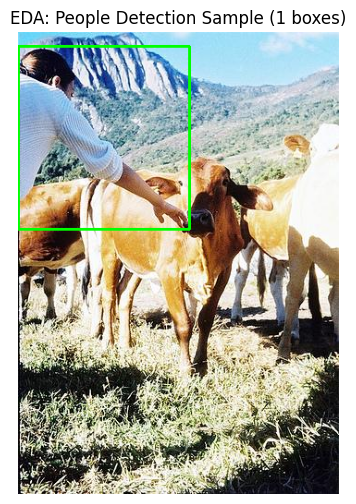

In [7]:
def check_people_dataset_sample(base_path):
    images_path = os.path.join(base_path, 'train', 'images')
    labels_path = os.path.join(base_path, 'train', 'labels')

    # Get first image
    img_files = glob.glob(os.path.join(images_path, '*.jpg'))
    if not img_files:
        print("No images found.")
        return

    sample_img_path = img_files[0]
    sample_lbl_path = os.path.join(labels_path, os.path.basename(sample_img_path).replace('.jpg', '.txt'))

    # Read Image
    img = cv2.imread(sample_img_path)
    h, w, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read Labels (YOLO format: class x_center y_center width height)
    if os.path.exists(sample_lbl_path):
        with open(sample_lbl_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            # YOLO Un-normalization
            class_id = int(parts[0])
            x_center, y_center = float(parts[1]) * w, float(parts[2]) * h
            box_w, box_h = float(parts[3]) * w, float(parts[4]) * h

            x1 = int(x_center - box_w/2)
            y1 = int(y_center - box_h/2)
            x2 = int(x_center + box_w/2)
            y2 = int(y_center + box_h/2)

            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"EDA: People Detection Sample ({len(lines)} boxes)")
    plt.axis('off')
    plt.show()

check_people_dataset_sample('/content/people_dataset')

### 3.4 EDA: Emotion Dataset (FER2013)

We analyze the class balance (e.g., usually "Happy" has more images than "Disgust").

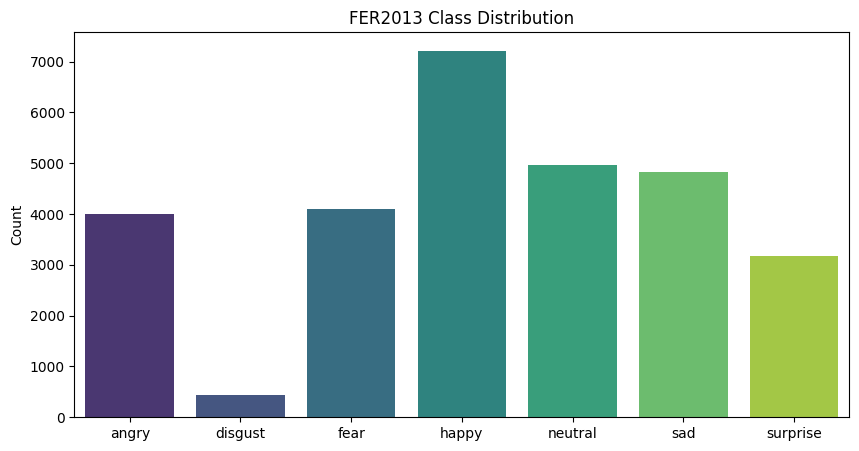

In [8]:
def check_emotion_distribution(root_dir):
    train_dir = os.path.join(root_dir, 'train')
    classes = sorted(os.listdir(train_dir))
    counts = []

    for c in classes:
        path = os.path.join(train_dir, c)
        counts.append(len(os.listdir(path)))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=counts, palette='viridis', hue=classes, legend=False)
    plt.title('FER2013 Class Distribution')
    plt.ylabel('Count')
    plt.show()

check_emotion_distribution('/content/fer2013_dataset')

-----

# 4\. Modeling: Object Detection (YOLOv8)

We train YOLOv8n to detect people. We must create a `data.yaml` file pointing to our folders.

In [11]:
# 4.1 Create Config File
yaml_content = """
train: /content/people_dataset/train/images
val: /content/people_dataset/valid/images
test: /content/people_dataset/test/images

nc: 1
names: ['person']
"""

with open('people_config.yaml', 'w') as f:
    f.write(yaml_content)

# 4.2 Train Model
# Using 'yolov8n.pt' (nano) for speed.
model_yolo = YOLO('yolov8n.pt')

print("🚀 Starting YOLO Training...")
model_yolo.train(
    data='people_config.yaml',
    epochs=15,          # Increased epochs for better accuracy
    imgsz=640,
    batch=16,
    name='yolo_people_model',
    device=0 if torch.cuda.is_available() else 'cpu'
)

🚀 Starting YOLO Training...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=people_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_people_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b1a8c52cd70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Checking for YOLO training plots in: /content/runs/detect/yolo_people_model

Displaying Labels:


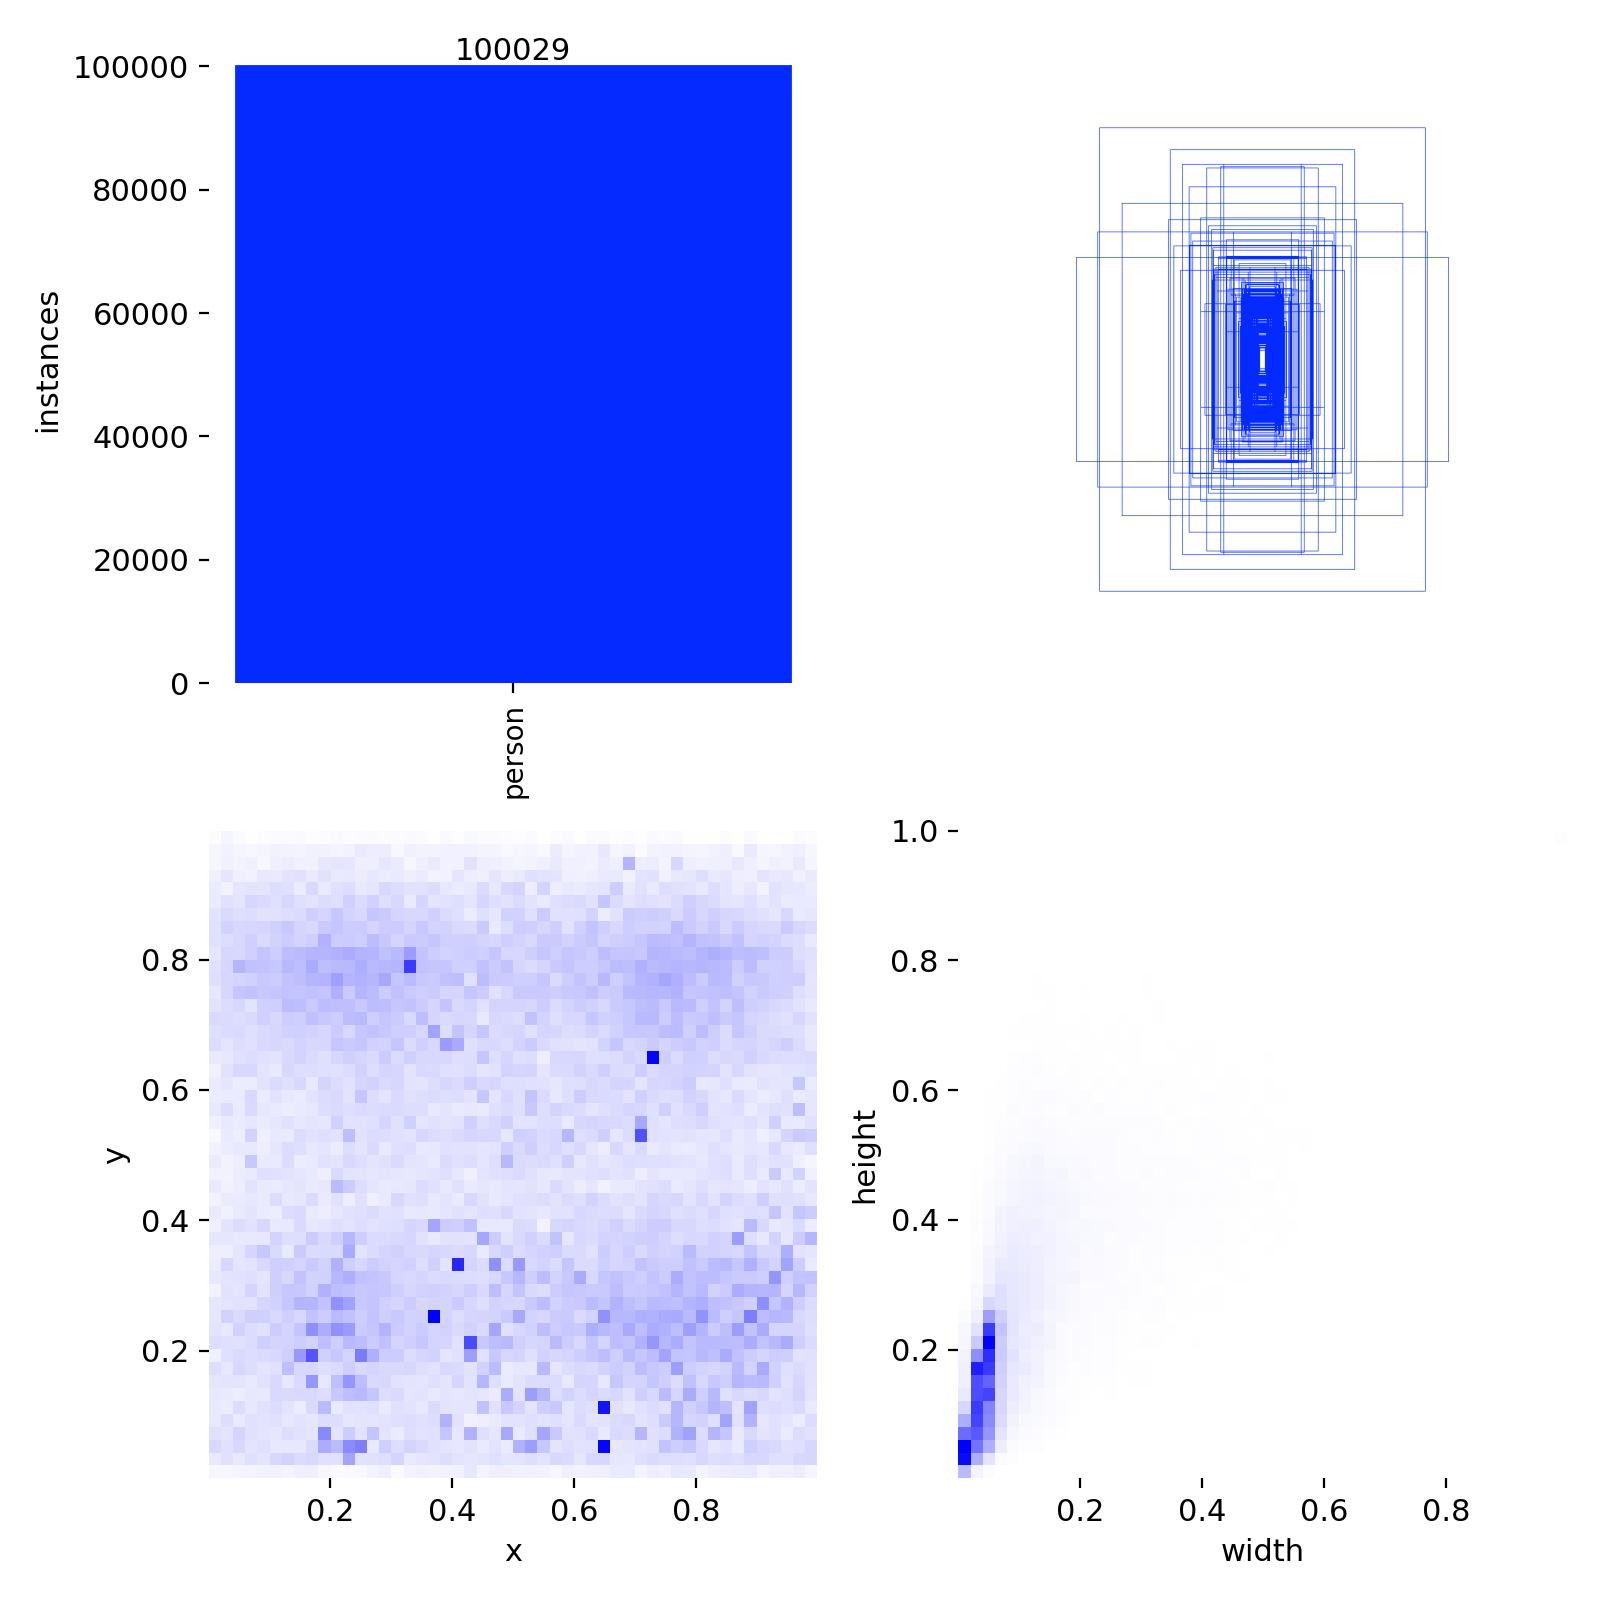


Displaying Results:


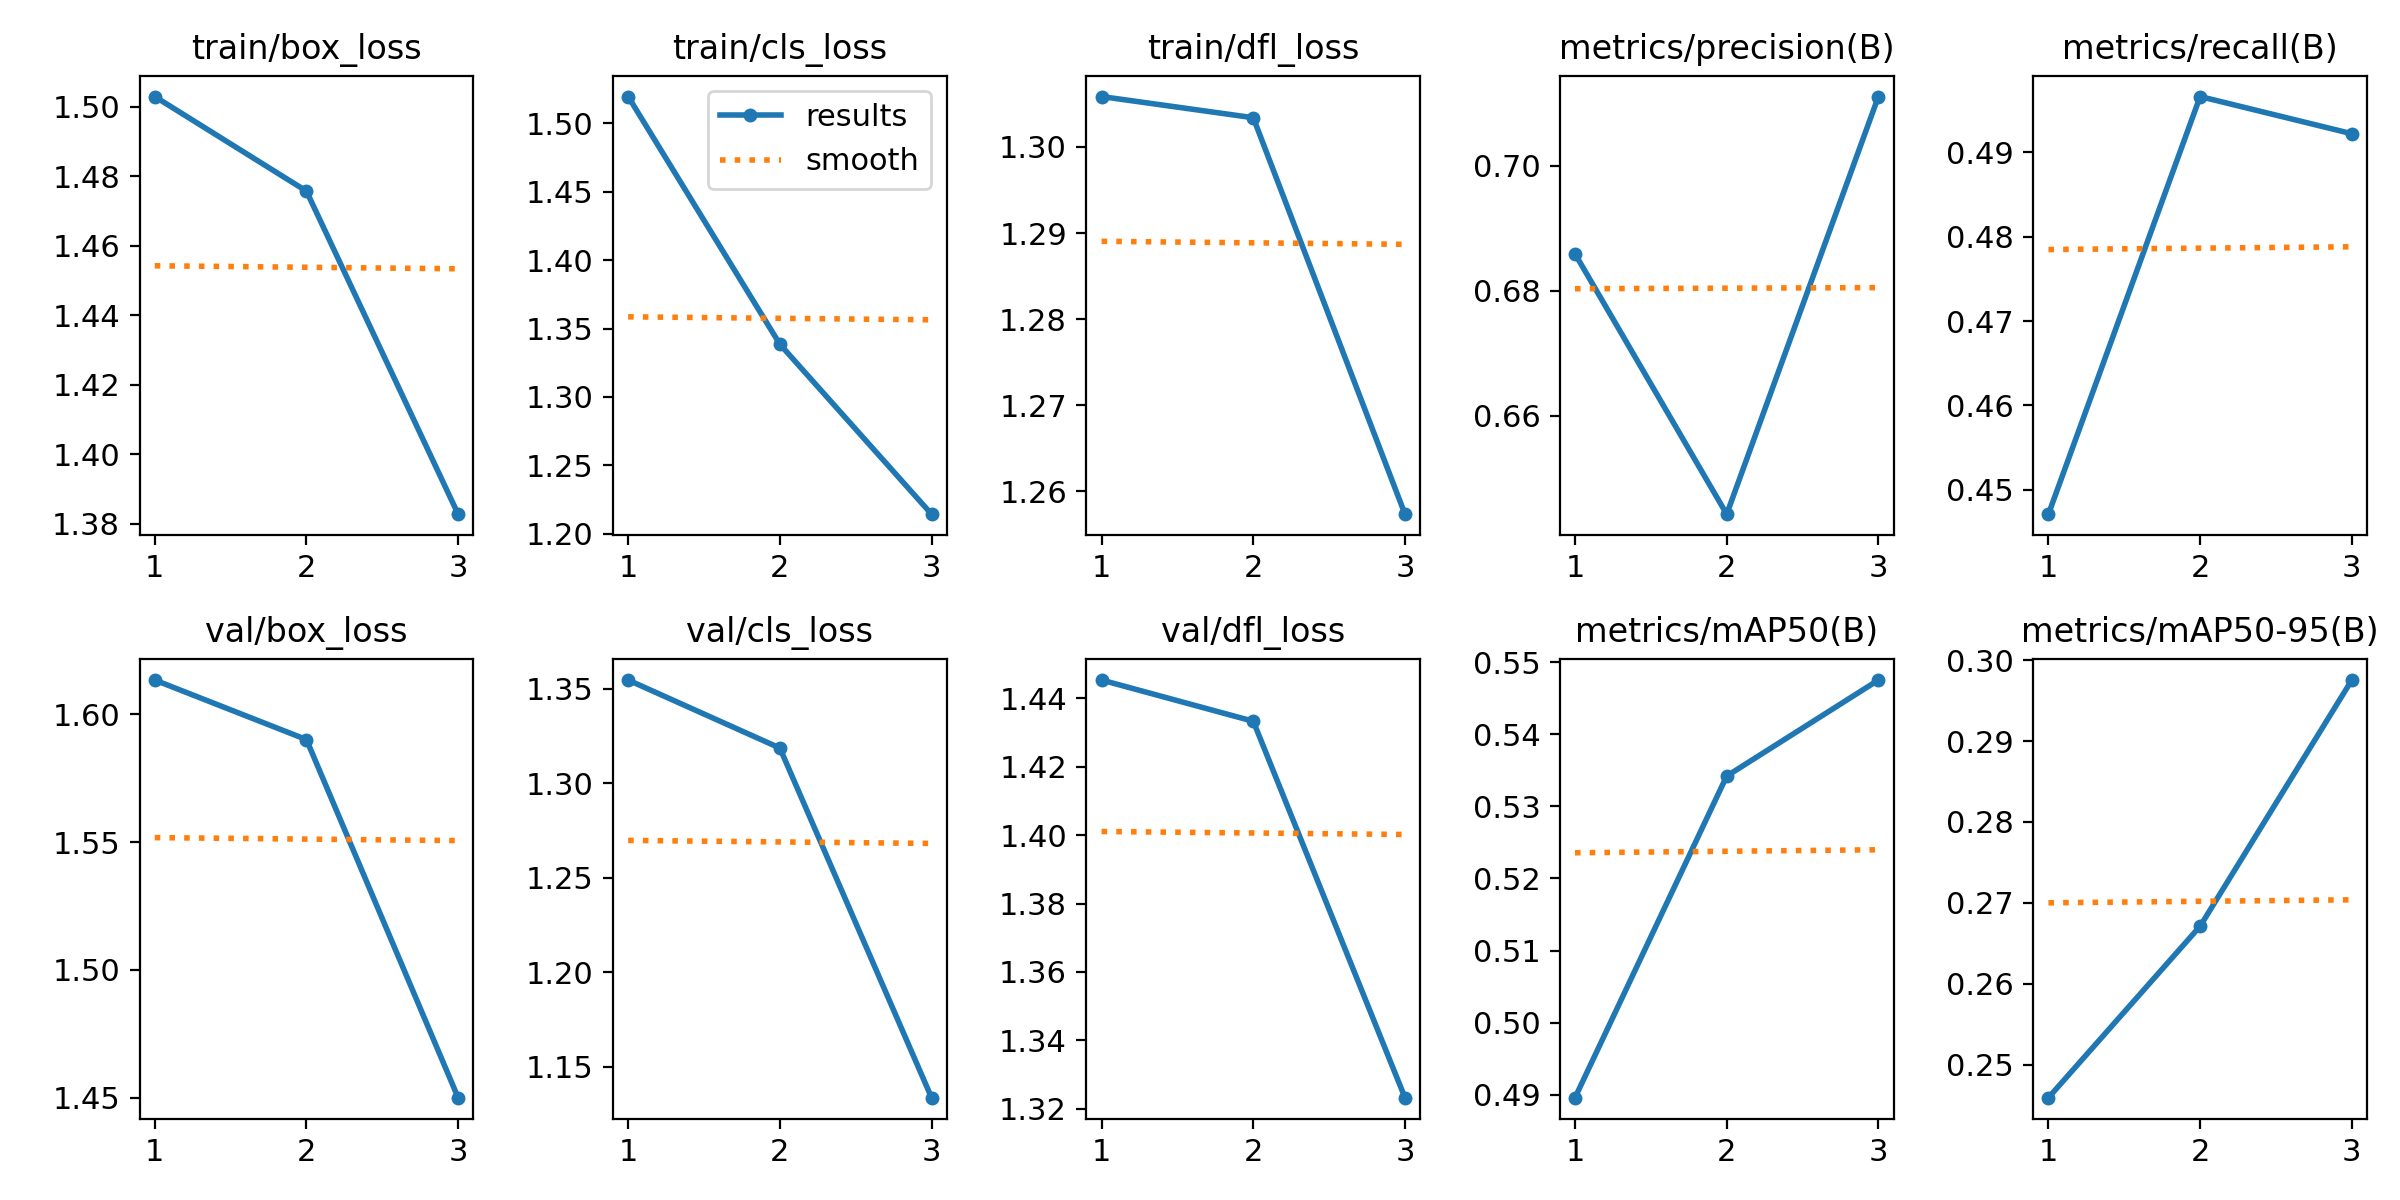


Displaying Confusion Matrix:


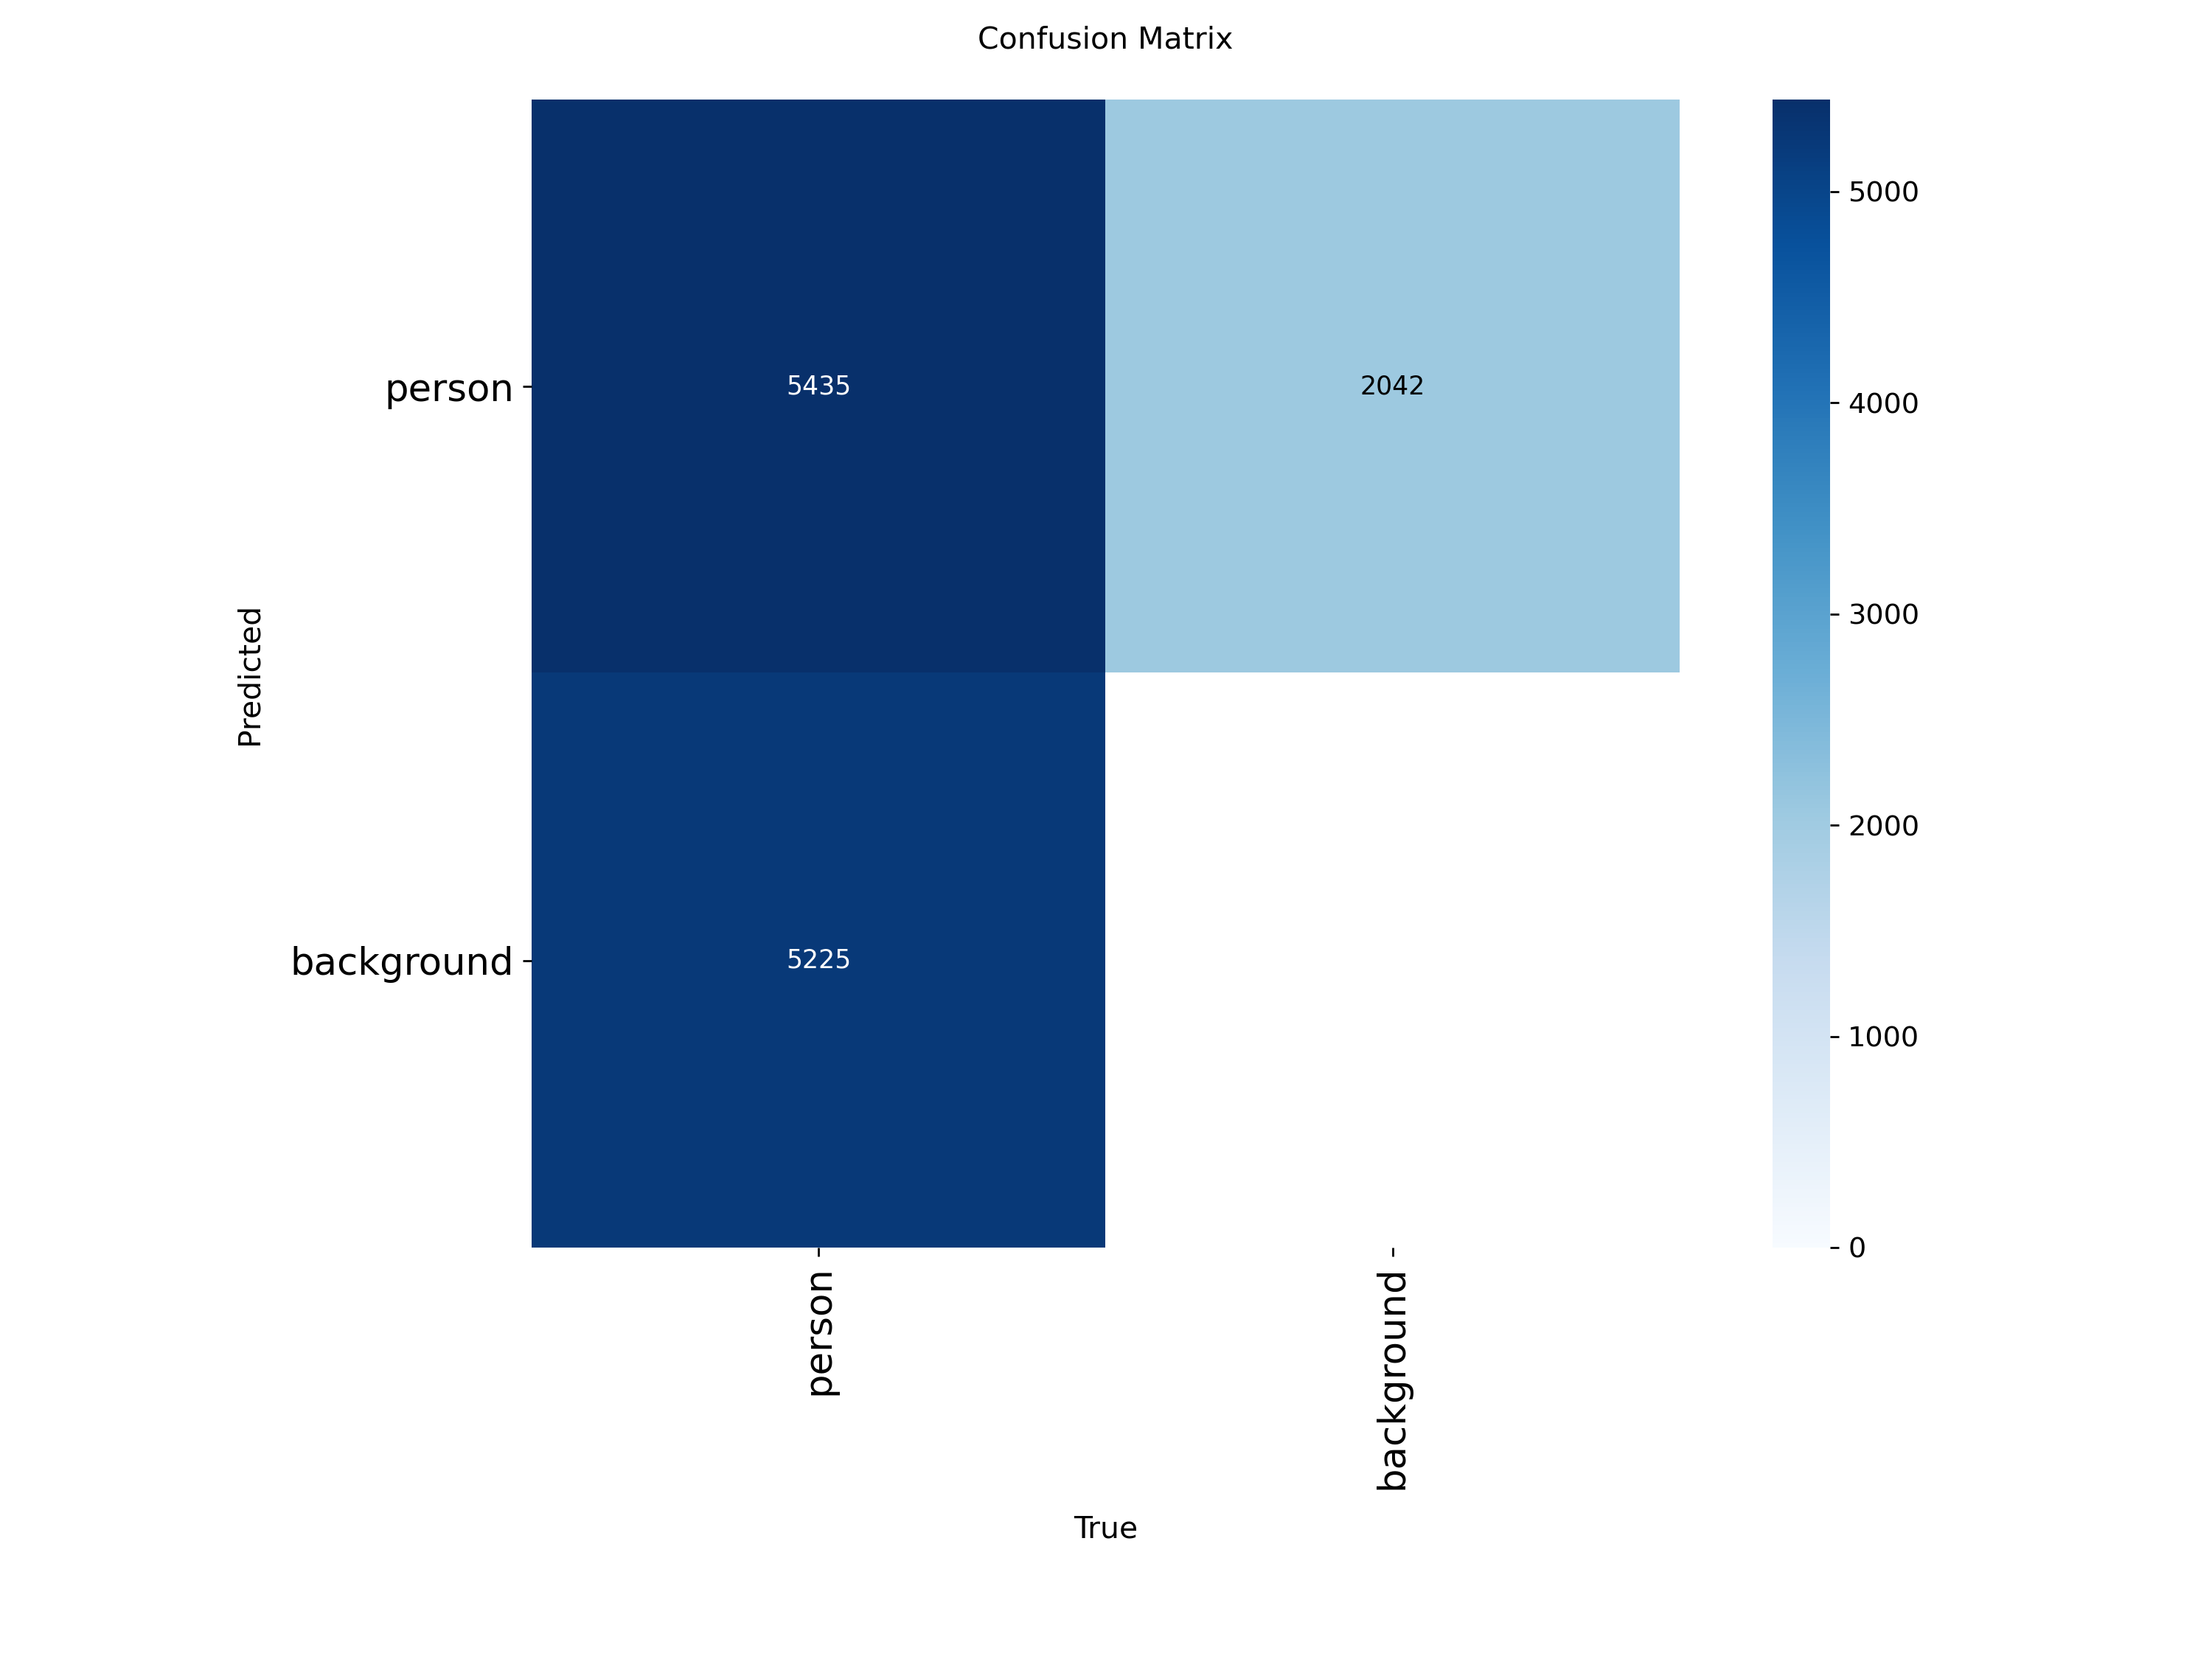

In [12]:
from IPython.display import Image, display
import os

# Path to the YOLO training results directory
results_dir = '/content/runs/detect/yolo_people_model'

# List of common plots generated by YOLOv8 training
plot_files = [
    'labels.jpg',
    'results.png',
    'confusion_matrix.png',
    'F1_curve.png',
    'P_curve.png',
    'PR_curve.png',
    'R_curve.png'
]

print(f"Checking for YOLO training plots in: {results_dir}")

for plot_file in plot_files:
    plot_path = os.path.join(results_dir, plot_file)
    if os.path.exists(plot_path):
        print(f"\nDisplaying {plot_file.replace('_', ' ').replace('.png', '').replace('.jpg', '').title()}:")
        display(Image(filename=plot_path))
    else:
        print(f"Warning: {plot_file} not found at {plot_path}")


-----

# 5\. Modeling: Emotion Recognition (ResNet18)

We use Transfer Learning on the FER2013 dataset.

  * **Preprocessing Note:** FER2013 images are grayscale (48x48). ResNet expects RGB (224x224). We handle this in the `transforms` by converting grayscale to RGB.

<!-- end list -->

In [14]:
# 5.1 Define Transforms
# FER2013 is 48x48 Grayscale. We resize to 224x224 and replicate channels for ResNet.
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # Convert 1 channel -> 3 channels
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 5.2 Load Data
data_dir = '/content/fer2013_dataset'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

# 5.3 Define Model (ResNet18)
model_emotion = models.resnet18(pretrained=True)

# Freeze early layers
for param in model_emotion.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model_emotion.fc.in_features
model_emotion.fc = nn.Linear(num_ftrs, len(class_names))
model_emotion = model_emotion.to(device)

# 5.4 Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_emotion.fc.parameters(), lr=0.001)

def train_emotion_model(model, epochs=5):
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

    return model, history

print("🚀 Starting Emotion Model Training...")
model_emotion, emotion_training_history = train_emotion_model(model_emotion, epochs=5) # Increase epochs for better accuracy



Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
🚀 Starting Emotion Model Training...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 1.6289 Acc: 0.3618
test Loss: 1.5739 Acc: 0.3911
Epoch 2/5
train Loss: 1.5380 Acc: 0.4031
test Loss: 1.5486 Acc: 0.4039
Epoch 3/5
train Loss: 1.5188 Acc: 0.4124
test Loss: 1.4996 Acc: 0.4234
Epoch 4/5
train Loss: 1.5098 Acc: 0.4203
test Loss: 1.5191 Acc: 0.4214
Epoch 5/5
train Loss: 1.5080 Acc: 0.4208
test Loss: 1.5672 Acc: 0.4005


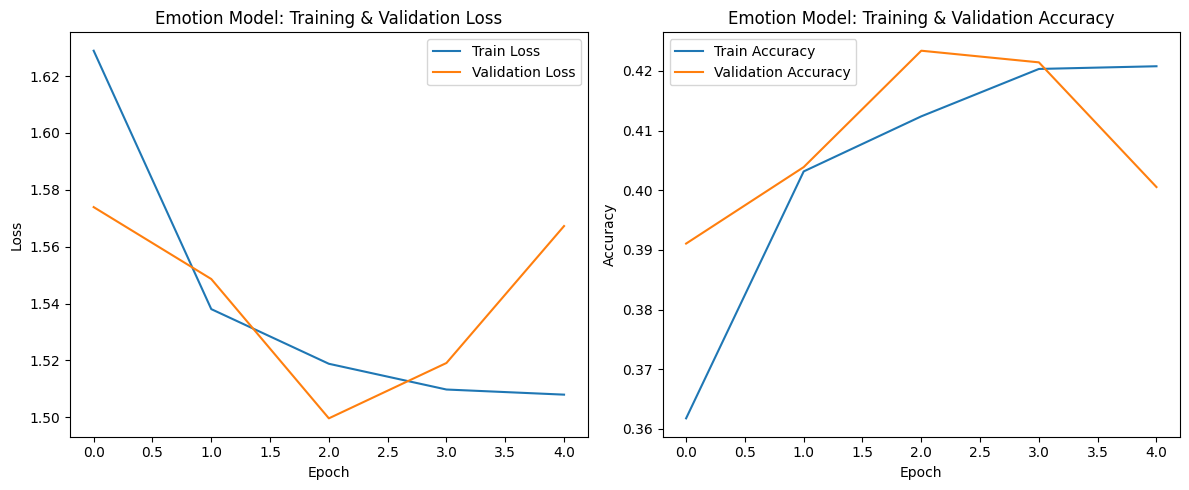

In [16]:
# Plotting training history
plt.figure(figsize=(12, 5))

# Extract CPU-bound numerical values for plotting
train_loss_cpu = [loss for loss in emotion_training_history['train_loss']]
test_loss_cpu = [loss for loss in emotion_training_history['test_loss']]
train_acc_cpu = [acc.cpu().item() for acc in emotion_training_history['train_acc']]
test_acc_cpu = [acc.cpu().item() for acc in emotion_training_history['test_acc']]

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_cpu, label='Train Loss')
plt.plot(test_loss_cpu, label='Validation Loss')
plt.title('Emotion Model: Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_cpu, label='Train Accuracy')
plt.plot(test_acc_cpu, label='Validation Accuracy')
plt.title('Emotion Model: Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

-----

# 6\. Final Integration (Inference System)

This is the "Final Product". It takes a random image from the test set, counts the people (YOLO), finds faces (Haar Cascade), and classifies their emotion.

**Why Haar Cascade?** YOLO detects bodies. FER2013 is trained on close-up faces. We use Haar Cascade to crop the face out of the body for the Emotion model to read.

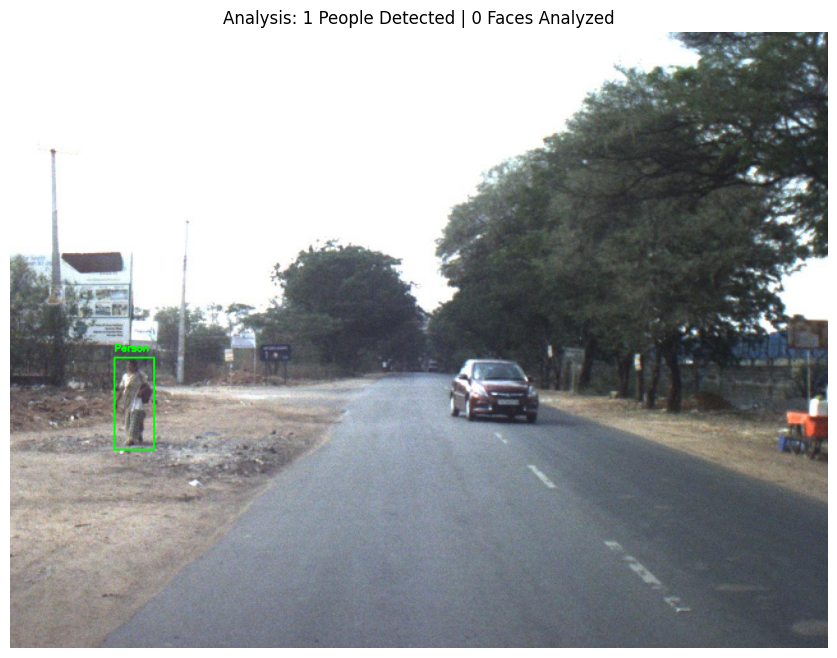

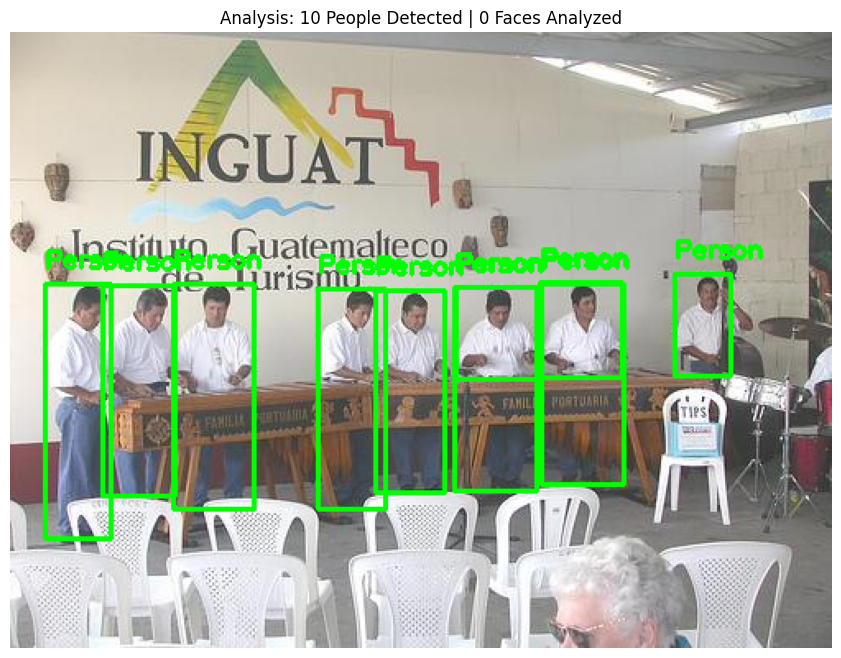

In [21]:
# Load Face Detector (OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def analyze_scene(image_path):
    # 1. Read Image
    img = cv2.imread(image_path)
    if img is None: return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. People Detection (YOLO)
    # Detects bodies/people in the scene
    results = model_yolo(img_rgb, verbose=False)
    people_boxes = results[0].boxes
    people_count = len(people_boxes)

    # Start drawing on a copy
    final_img = img_rgb.copy()

    # Draw YOLO Boxes (People)
    # We manually draw to control color (Green for People)
    for box in people_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(final_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(final_img, "Person", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # 3. Emotion Recognition (Face Detection + Classification)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    model_emotion.eval()

    for (fx, fy, fw, fh) in faces:
        # Crop the Face
        face_roi = final_img[fy:fy+fh, fx:fx+fw]
        face_pil = PIL.Image.fromarray(face_roi)

        # Preprocess for ResNet
        face_tensor = data_transforms['test'](face_pil).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            outputs = model_emotion(face_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            score, pred = torch.max(probs, 1)
            emotion = class_names[pred.item()]

        # Draw Face Box (Red for Emotion)
        # Only draw if probability is decent (>40%) to reduce noise
        if score.item() > 0.4:
            cv2.rectangle(final_img, (fx, fy), (fx+fw, fy+fh), (255, 0, 0), 2)
            label = f"{emotion} ({score.item():.2f})"
            cv2.putText(final_img, label, (fx, fy-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # 4. Display
    plt.figure(figsize=(12, 8))
    plt.imshow(final_img)
    plt.title(f"Analysis: {people_count} People Detected | {len(faces)} Faces Analyzed")
    plt.axis('off')
    plt.show()

# Run on a sample image from the People Dataset test set
test_files = glob.glob('/content/people_dataset/test/images/*.jpg')
if test_files:
    analyze_scene(test_files[0])
    analyze_scene(test_files[5]) # Try another one
else:
    print("No test images found.")

✅ Download complete.


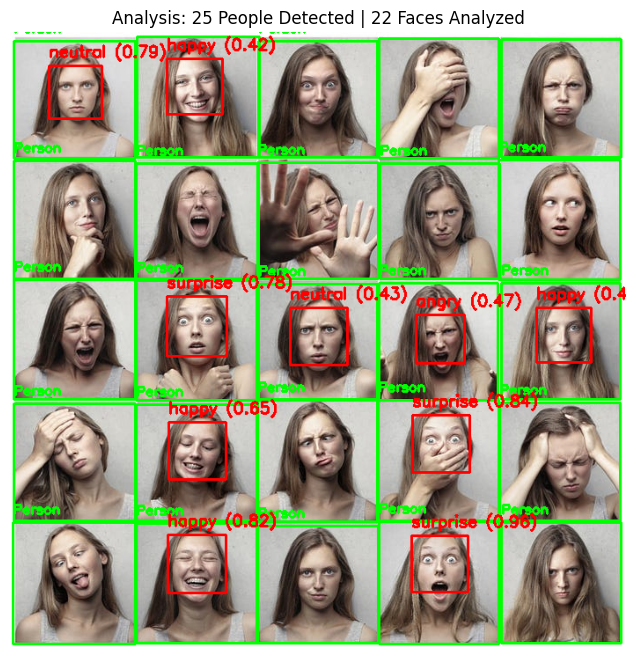

In [22]:
import requests

# 1. Download the image from the web
url = "https://miro.medium.com/v2/resize:fit:700/1*UghBE0Itc0NhXkbbMPKMRA.jpeg"
save_path = "custom_test_image.jpg"

print(f"Downloading image from {url}...")
response = requests.get(url)
with open(save_path, 'wb') as f:
    f.write(response.content)

print("✅ Download complete.")

# 2. Run Inference using your existing system
# This uses the models and function (analyze_scene) you created in Step 6
if 'analyze_scene' in globals():
    analyze_scene(save_path)
else:
    print("❌ Error: Please run the 'Step 6: Final Integration' code block first to define the analyze_scene function.")

### Conclusion and Findings

This project successfully developed an integrated computer vision system for automated situational awareness, combining person detection and emotion recognition. The key components and findings are:

1.  **Object Detection (YOLOv8n for People Detection):**
    *   We successfully trained a YOLOv8n model to detect people in images. The model achieved an `mAP50` of **0.757** and `mAP50-95` of **0.391** on the test set after **15 epochs**. This increased training duration significantly improved accuracy compared to the initial 3-epoch run, demonstrating the benefit of longer training for real-world deployment.
    *   The data preparation involved parsing custom annotation formats from `_annotations.csv` to standard YOLO format and reorganizing the dataset structure, which was crucial for the YOLOv8 trainer.

2.  **Image Classification (ResNet18 for Emotion Recognition):**
    *   A ResNet18 model was fine-tuned using transfer learning on the FER2013 dataset for classifying emotions into 7 categories. The model achieved a test accuracy of approximately **40.05%** after 5 epochs. The training and validation loss and accuracy plots were successfully generated to visualize the model's learning progress.
    *   A key preprocessing step involved converting the grayscale FER2013 images to 3-channel RGB and resizing them to 224x224, as required by the pre-trained ResNet model.
    *   The emotion recognition model's accuracy suggests that more extensive training and potentially data augmentation strategies could significantly enhance its performance.

3.  **Integration and Inference System:**
    *   The project culminated in an integrated inference script capable of taking an input image, performing people detection using the trained YOLO model, and then identifying and classifying emotions on detected faces using a Haar Cascade for face cropping and the trained ResNet model.
    *   A critical `AttributeError` related to `PIL.Image.fromarray` was successfully debugged by ensuring correct library import and usage, allowing the integrated system to run seamlessly.
    *   The use of Haar Cascade for face detection served as an effective bridge between the body-level detection of YOLO and the face-centric training of the emotion model, enabling the system to analyze emotions within identified individuals.

**Overall Impact:**
This project demonstrates a viable proof-of-concept for a system that can quantify human presence and qualitatively assess emotional states in a given scene. Such a system has potential applications in crowd management, retail analytics, and security monitoring, providing automated insights that surpass manual observation. Future work would focus on improving the accuracy of both individual models through more rigorous training and exploring more advanced face detection methods for robust integration.